## Importer les librairies

In [152]:
using CSV, DataFrames, Distributions, Gadfly, MLBase, Random, Statistics
using GLM
import StatsBase       # Pour la standardisation des variables
using LinearAlgebra
include("functions.jl")
using Plots            # Pour la heatmap du KNN

## Visualiser les données (à expliquer)

<img id="myimage" src="pair.png" style=" height:500px; width:500px;">


<div class="img-zoom-container", style="overflow:auto; height:550px; width:5669px;">
  <img id="myimage" src="pair.png" style=" height:5669px; width:5669px;">>
</div>

In [153]:
data = CSV.read("train.csv")

Gadfly.set_default_plot_size(150cm, 150cm)

matrix = Array{Plot}(undef, 10, 10)

column = names(data)[2:end-1]
i = 1
for c1 in column
    j = 1
    for c2 in column
        if (i == j)
            matrix[i,j] = Gadfly.plot(data, x = c1, Geom.histogram(bincount = 30), color = :diagnosis)
        else
            matrix[i,j] = Gadfly.plot(data, x = c1, y = c2, color = :diagnosis)
        end
        j+=1
    end 
    i+=1
end 

#grid = gridstack(matrix) # graphing is so computationnally hard that it makes the jupyter bug
println("Graphing is done")

Graphing is done


# KNN

## Traiter les données (PCA)

In [154]:
data = CSV.read("train.csv")
y_train = data[end]


X_train = data[2:end-1] #omit id and diagnosis

data_test = CSV.read("test.csv")
X_test = data_test[2:end]

id_test = data_test[1]


println(size(X_train))
println(size(X_test))

length_train = size(X_train)[1]
length_test = size(X_train)[1]


new_X = vcat(X_train, X_test)

(455, 10)
(114, 10)


569×10 DataFrame. Omitted printing of 4 columns
│ Row │ radius  │ texture │ perimeter │ area    │ smoothness │ compactness │
│     │ Float64 │ Float64 │ Float64   │ Float64 │ Float64    │ Float64     │
├─────┼─────────┼─────────┼───────────┼─────────┼────────────┼─────────────┤
│ 1   │ 16.641  │ 21.3452 │ 110.798   │ 901.347 │ 0.112388   │ 0.145148    │
│ 2   │ 13.6884 │ 21.1035 │ 90.5878   │ 578.09  │ 0.0941204  │ 0.101193    │
│ 3   │ 12.9131 │ 14.3055 │ 85.3309   │ 511.539 │ 0.0863069  │ 0.136213    │
│ 4   │ 12.9474 │ 15.1198 │ 86.2821   │ 539.445 │ 0.0925851  │ 0.0849802   │
│ 5   │ 19.4972 │ 24.8959 │ 127.491   │ 1200.37 │ 0.101691   │ 0.0989018   │
│ 6   │ 17.9685 │ 23.9732 │ 113.391   │ 995.763 │ 0.0879695  │ 0.0705786   │
│ 7   │ 23.3328 │ 26.9409 │ 158.255   │ 1685.51 │ 0.113154   │ 0.208636    │
│ 8   │ 14.2786 │ 19.7755 │ 97.6468   │ 627.095 │ 0.076918   │ 0.224775    │
│ 9   │ 15.1174 │ 17.6523 │ 97.2838   │ 674.5   │ 0.11765    │ 0.129638    │
│ 10  │ 11.6321 │ 17.1527 │ 72.8543   │ 429.276 │ 0.0749088  │ 0.0359126   │
⋮
│ 559 │ 15.3516 │ 22.3249 │ 99.0566   │ 697.953 │ 0.0912551  │ 0.104306    │
│ 560 │ 9.7714  │ 17.9631 │ 60.9506   │ 275.792 │ 0.0705931  │ 0.0249617   │
│ 561 │ 11.5087 │ 16.3981 │ 76.1231   │ 417.702 │ 0.112233   │ 0.0907565   │
│ 562 │ 15.3293 │ 11.6333 │ 101.55    │ 729.752 │ 0.126516   │ 0.153508    │
│ 563 │ 19.6112 │ 18.7512 │ 129.102   │ 1178.62 │ 0.10717    │ 0.143977    │
│ 564 │ 19.132  │ 26.5572 │ 125.238   │ 1123.88 │ 0.102392   │ 0.144759    │
│ 565 │ 14.4198 │ 13.5716 │ 91.47     │ 649.614 │ 0.100074   │ 0.0777058   │
│ 566 │ 12.3128 │ 17.0445 │ 78.4351   │ 482.039 │ 0.0770959  │ 0.0333872   │
│ 567 │ 7.69801 │ 24.4124 │ 48.3244   │ 186.477 │ 0.052733   │ 0.0439509   │
│ 568 │ 27.4134 │ 26.1753 │ 187.038   │ 2509.08 │ 0.106841   │ 0.198944    │
│ 569 │ 12.3808 │ 18.5155 │ 80.1345   │ 487.498 │ 0.100624   │ 0.104961    │

In [155]:
X = convert(Array{Float64}, new_X)

Z = standardize(X)

# Décomposition en valeurs singulières de la matrice rectangulaire Z
F = svd(Z)

# Extraction de la matrice U
U = F.U

# Extraction de la matrice V
V = F.V

# Extraction des valeurs singulières
γ = F.S

10-element Array{Float64,1}:
 55.71037587860671
 37.79295983939699
 22.41097056629253
 16.862398849558204
 14.661048168194535
  8.481287124207219
  6.82690850296839
  4.451200683899222
  2.6590076981120983
  1.041803968620491

## Faire le modèle KNN

### Le concept en général

Le K-nearest neighbors algorithm est un algorithme de classification assez simple. Il se base sur le fait que les features points d'une classe devraient, généralement, se trouver proche des autres points de la même classe (ils devraient être clustered si nous normalisons les données). En se basant sur ce principe, un KNN va tout simplement prendre ces prédictions sur la distance que le point du testing set a avec les points du training set. Une fois que ces distances se font calculer, il faudra prendre les K points qui sont les plus proches du point à prédire. Grâce aux K points trouvés et à leurs classes respectives, nous allons pouvons classifier nos nouveaux points (les points du testing set).

### Des aspects spécifiques à notre implémentation

Premièrement, le KNN que nous avons implémenté utilise la distance euclidienne entre les points (aussi connu sous le nom de "L2 norm"). C'est important de le mentionné, car il y a plus d'une façon de faire le calcul d'une distance. Toutefois, nous avons choisis celle-là vu qu'elle est plus populaire. Ensuite, ce qu'il faut savoir c'est qu'un KNN, en général, nécessite que ces entrées soient normalisé. En effet, cela est du au fait que nous trouvons la distance entre deux points et que si les entrées ne sont pas normalisés, alors une différence dans l'orde de grandeur des variables explicatives va jouer sur l'importance des variables (une variable avec une plus grande orde de grandeur pourrait sembler plus importante ce qu'elle est vraiment vu que les distances de cette variable seront plus grandes). Finalement, pour trouver un K qui devrait donner un bon score, il est courant de faire du K-fold cross validation avec le training data pour savoir quel K pourrait être bon avec le testing set (celui qui pourrait bien généraliser). De plus, nous avons limités notre recherche du K optimal à des K impairs pour la simple raison que nous voulons que la classification se fasse avec une majorité (ce qui pourrait ne pas arriver si la moitié des K points les plus proches soient d'une certaine classe et l'autre moitié de l'autre classe).

In [156]:
function calculateDist(vec1, vec2)
    dist = 0
    taille = size(vec1)[1]
    for i = 1:taille
        dist += (vec1[i]-vec2[i])^2
    end
    
    return dist
end

function findMin(n, tab, used_indexes)
    mini_pos = 1
    mini = tab[mini_pos]
    
    for i = 2:length(tab)
        if (tab[i] < mini && !(i in used_indexes))
            mini_pos = i
            mini = tab[i]
        end
    end
    return mini_pos
end


function findIndexesNSmallest(n, tab)
    temp = copy(tab)
    indexes = []
    for i = 1:n
        new_index = findMin(n, temp, indexes)
        push!(indexes, new_index)
    end
    

    return indexes
end

function predict(k, X_train, y_train, X_test) #works best with odd k    
    nb_data = size(X_train)[1]
    
    distances = []
    for elem in 1:nb_data
        push!(distances, calculateDist(X_test, X_train[elem, :]))
    end
    
    indexes_distances = findIndexesNSmallest(k, distances)
    
    nb_0 = 0
    for index in indexes_distances
        if (y_train[index] == 0)
            nb_0 += 1
        end
    end
    
    return convert(Int8, (nb_0 < k - nb_0))
    
end

function knn(k, X_train, y_train, X_test)
    ans = []
    for elem in 1:size(X_test)[1]
        push!(ans, predict(k, X_train, y_train, X_test[elem, :]))
    end
    return ans
end

knn (generic function with 1 method)

## K-fold cross validation

In [157]:
# K-cross validation
function findAllIndexes(length, nb_blocks)
    return [(convert(Int16, floor((i-1)*length/nb_blocks))+1, convert(Int16, floor(i*length/nb_blocks))) for i = 1:nb_blocks]
end

function countTFPN(t_label, predictions)
    TP, FP, FN, TN = 0, 0, 0, 0
    taille = size(t_label)[1]
    for i = 1:taille
        if(t_label[i] == 1 && predictions[i] == 1)
            TP += 1
        elseif(t_label[i] == 1 && predictions[i] == 0)
            FN += 1
        elseif(t_label[i] == 0 && predictions[i] == 1)
            FP += 1
        elseif(t_label[i] == 0 && predictions[i] == 0)
            TN += 1
        end
            
    end
    return TP, FP, FN, TN
end

function computeMetrics(t_label, predictions)
    TP, FP, FN, TN = countTFPN(t_label, predictions)
    precision, recall, accuracy = (TP/(TP + FP)), (TP/(TP + FN)), ((TP+TN)/(TP + FP + FN + TN))
    return [precision, recall, accuracy]
end

function split_train_test(X, y, index)
    sub_X_train = [X[1 : index[1]-1, :]; X[index[2] : end, :]]
    sub_X_test = X[index[1] : index[2], :]
    sub_y_train = [y[1 : index[1]-1]; y[index[2] : end]]
    true_y_test = y[index[1] : index[2]]
    return sub_X_train, sub_X_test, sub_y_train, true_y_test
end


function KCrossValidation(k, X, y, nb_blocks = 15)
    indexes = findAllIndexes(size(X_test)[1],nb_blocks)
    ans = []
    for interval = indexes
        sub_X_train, sub_X_test, sub_y_train, true_y_test = split_train_test(X, y, interval)
        sub_y_test =  knn(k, sub_X_train, sub_y_train, sub_X_test)
        push!(ans, computeMetrics(true_y_test, sub_y_test))
    end
    temp = mean(ans)
    return temp
end


KCrossValidation (generic function with 2 methods)

## Trouver le K qui minimise l'erreur selon les métriques

In [158]:
mat = γ[1] *U[:, 1]*V[:,1]'

X_train = mat[1:length_train, :]
X_test = mat[length_train+1:end, :]

println(size(X_train))
println(size(X_test))
println(size(y_train))

(455, 10)
(114, 10)
(455,)


In [159]:
spy_matrix = Array{AbstractFloat}(undef, 10, 10)
spy_matrix_text = Array{Plots.PlotText}(undef, 10, 10)
for j = 1:10
    println("Index : ", j)
    
    mat = γ[1] *U[:, 1]*V[:,1]'
    for k = 2:j
        mat += γ[k] *U[:, k]*V[:,k]'
    end
    

    X_train = mat[1:length_train, :]

    X_test = mat[length_train+1:end, :]
    metrics = []
    gen_temp = 1:2:19
    for i = 1:2:19
        temp = KCrossValidation(i, X_train, y_train)
        if (i ==  1)
            metrics = [[elem] for elem = temp]
        else
            taille = size(temp)[1]
            for index = 1:taille
                push!(metrics[index], temp[index])
            end
        end

    end
    ks = [i for i = gen_temp]

    
    precision = metrics[1]
    recall = metrics[2]
    for index = 1:length(precision)
        f1 = 2*(precision[index] * recall[index])/(precision[index] + recall[index])
        println("F1 score ",index*2 - 1,  "NN : ", f1)
        spy_matrix[index,j] = f1
        spy_matrix_text[index,j] = Plots.text(round(f1, digits=4),9)
    end
    
end


Index : 1
F1 score 1NN : 0.8891101431238333
F1 score 3NN : 0.9159625362172359
F1 score 5NN : 0.9152348224513173
F1 score 7NN : 0.9240117521367521
F1 score 9NN : 0.9240117521367521
F1 score 11NN : 0.9159625362172359
F1 score 13NN : 0.9159625362172359
F1 score 15NN : 0.9159625362172359
F1 score 17NN : 0.9159625362172359
F1 score 19NN : 0.9159625362172359
Index : 2
F1 score 1NN : 0.8991426611796983
F1 score 3NN : 0.9336109458655562
F1 score 5NN : 0.9277777777777777
F1 score 7NN : 0.9336109458655562
F1 score 9NN : 0.9160838218448891
F1 score 11NN : 0.8992931164642096
F1 score 13NN : 0.9169392287502525
F1 score 15NN : 0.9338885583977791
F1 score 17NN : 0.9027008547008547
F1 score 19NN : 0.90791709140333
Index : 3
F1 score 1NN : 0.9002261978202755
F1 score 3NN : 0.9388560157790926
F1 score 5NN : 0.9220883534136545
F1 score 7NN : 0.9388560157790926
F1 score 9NN : 0.9388560157790926
F1 score 11NN : 0.9247914581247915
F1 score 13NN : 0.9338885583977791
F1 score 15NN : 0.9388560157790926
F1 scor

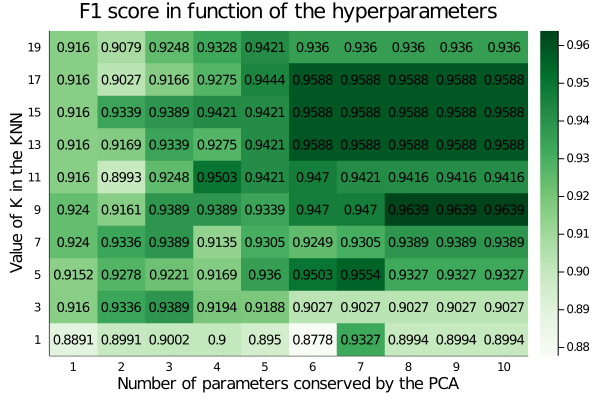

In [160]:
Gadfly.set_default_plot_size(12cm, 12cm)
Axis_k = ["1","3","5","7","9","11","13","15","17","19"]
Axis_PCA = ["1","2","3","4","5","6","7","8","9", "10"]
p = heatmap(Axis_PCA,Axis_k,spy_matrix,
    ylabel ="Value of K in the KNN",
    xlabel = "Number of parameters conserved by the PCA",
    title = "F1 score in function of the hyperparameters",
    c=:Greens
)
annotate!( vec(tuple.((1:length(Axis_PCA))'.-0.5, (1:length(Axis_k)).-0.5, spy_matrix_text)) )

## Faire les prédictions sur le testing set 

Nous allons prendre un des K trouver précédemment qui avait obtenu un bon score.

In [161]:
k = 5

mat = γ[1] *U[:, 1]*V[:,1]'
for i = 2:7
    mat += γ[i] *U[:, i]*V[:,i]'
end
X_train = mat[1:length_train, :]
X_test = mat[length_train+1:end, :]

y_test = knn(k, X_train, y_train, X_test)
prediction = DataFrame(id = id_test, diagnosis = y_test)
CSV.write("KNN.csv",prediction)

"KNN.csv"

### Conclusion de la section KNN

Le score obtenu avec le KNN est satisfaisant. Lorsque nous avons fait le K-fold cross validation nous avons pu voir que certaines valeurs de K et que certains nombres de paramètres conservés par le PCA obtiennent de meilleurs résultats que d'autres. Avec quelques essais sur Kaggle, nous avons déterminé que les hyper-paramètres qui donnent le meilleur résultat est lorsque le K = 5 et que le nombre de paramètres utilisés pour le PCA = 7. Le f1 score obtenu avec le K-fold cross validation est de 0.9481, mais lorsque nous l'avons rentré sur Kaggle, nous avons obtenu un score de 0.89743.

# Bayesien Naif

In [162]:
Gadfly.set_default_plot_size(15cm, 10cm)

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [163]:
data = CSV.read("train.csv")
first(data,5)

5×12 DataFrame. Omitted printing of 6 columns
│ Row │ id    │ radius  │ texture │ perimeter │ area    │ smoothness │
│     │ Int64 │ Float64 │ Float64 │ Float64   │ Float64 │ Float64    │
├─────┼───────┼─────────┼─────────┼───────────┼─────────┼────────────┤
│ 1   │ 1     │ 16.641  │ 21.3452 │ 110.798   │ 901.347 │ 0.112388   │
│ 2   │ 2     │ 13.6884 │ 21.1035 │ 90.5878   │ 578.09  │ 0.0941204  │
│ 3   │ 3     │ 12.9131 │ 14.3055 │ 85.3309   │ 511.539 │ 0.0863069  │
│ 4   │ 4     │ 12.9474 │ 15.1198 │ 86.2821   │ 539.445 │ 0.0925851  │
│ 5   │ 5     │ 19.4972 │ 24.8959 │ 127.491   │ 1200.37 │ 0.101691   │

In [164]:
# Séparation du jeu de données
malign = filter(row -> row.diagnosis == 1, data)
benign = filter(row -> row.diagnosis == 0, data)
n₁ = size(malign, 1)
n₀ = size(benign, 1)
n = n₁ + n₀

455

## 2. Loi prédictive

Après avoir réalisé les calculs pour trouver la loi prédictive pour une loi normale considérant nos a priori non informatifs, on s'assurera qu'elle correspond aussi à une réalisation d'échantillonnage.

In [165]:
loi_inconnue = Normal(5, 2)

Normal{Float64}(μ=5.0, σ=2.0)

In [166]:
n = 150
y = rand.(loi_inconnue for i=1:n)

150-element Array{Float64,1}:
 5.782645780119243
 5.152260834425908
 5.347346953670563
 7.022449490624472
 5.5254157803539234
 3.9636121801545317
 3.0588419709574968
 4.084423579574383
 5.0935804356537115
 4.174629498105459
 5.613131718440617
 2.509065690580399
 3.728189457013116
 ⋮
 5.819717863368822
 1.2189328813061637
 1.9956026621660703
 6.91840885910054
 1.8414582640549937
 6.7408969438389335
 1.924498240034965
 3.1944780721975494
 2.6741378544116925
 2.4016615289971526
 3.820174452271911
 5.027907103107599

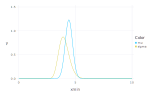

In [167]:
ȳ = mean(y)
SST = sum((y .- ȳ).^2)
s = SST / (n-1)
mμ = LocationScale(ȳ, s/sqrt(n), TDist(n-1))
mσ² = InverseGamma((n-1)/2, 1/2*SST)
Gadfly.plot(
    layer(x -> pdf(mμ, x), 0, 10, color=["mu"]),
    layer(x -> pdf(mσ², x), 0, 10, color=["sigma"])
)

In [168]:
fucked_up_variance = (n+1) * (SST) / (n * (n-2))
dist_pred = LocationScale(ȳ, sqrt(fucked_up_variance), TDist(n-2))

LocationScale{Float64,TDist{Float64}}(
μ: 4.421393622122494
σ: 2.003365834972581
ρ: TDist{Float64}(ν=148.0)
)


In [169]:
# Gibbs avec densités marginales
quantity = 1000000
ỹ = zeros(quantity)
for i=1:quantity
    μ_rand = rand(mμ)
    σ_rand = sqrt(rand(mσ²))
    ỹ[i] = rand(Normal(μ_rand, σ_rand))
end

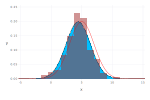

In [170]:
Gadfly.plot(
    layer(x=y, alpha=[0.5],Geom.histogram(bincount=floor(sqrt(n)), density=true), Theme(default_color=colorant"brown")),
    layer(x -> pdf(dist_pred, x), -30, 30, Theme(default_color=colorant"black")),
    layer(x -> pdf(loi_inconnue, x), -30, 30, Theme(default_color=colorant"red")),
    layer(x=ỹ, Geom.histogram(bincount=floor(sqrt(quantity)), density=true)),
    Coord.cartesian(xmin=-5, xmax=15)
)

En noir : loi prédictive <br>
En rouge: loi inconnue <br>
En bleu: valeurs d'échantillonnage <br>

## 3. Application des lois aux données

Pour chaque attribut, on représentera la distribution prédictive.

In [171]:
# Calcul du modèle
function loi_predictive(dataset::Array{Float64})
    ȳ = mean(dataset)
    n = length(dataset)
    SST = sum((dataset .- ȳ).^2)
    fucked_up_variance = (n+1) * (SST) / (n * (n-2))
    return LocationScale(ȳ, sqrt(fucked_up_variance), TDist(n-2))
end

loi_predictive (generic function with 1 method)

In [172]:
n = length(data[!, :id])

455

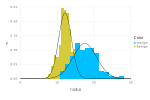

In [173]:
tag = :radius
pred_radius_0 = loi_predictive(benign[!, tag])
pred_radius_1 = loi_predictive(malign[!, tag])
Gadfly.plot(
    layer(x->pdf(pred_radius_0, x), 0, 30, Theme(default_color=colorant"black")),
    layer(x->pdf(pred_radius_1, x), 0, 30, Theme(default_color=colorant"black")),
    layer(malign, x=tag, Geom.histogram(bincount=floor(sqrt(n₁)), density=true), color = ["malign"]),
    layer(benign, x=tag, alpha=[0.75], Geom.histogram(bincount=floor(sqrt(n₀)), density=true), color = ["benign"])
)

In [174]:
tags = [:radius,:texture,:perimeter,:area,:smoothness,:compactness,
    :concavity,:concave_points,:symmetry,:fractal_dimension]
plots = []
preds_0 = []
preds_1 = []
for tag in tags
    pred_0 = loi_predictive(benign[!, tag])
    pred_1 = loi_predictive(malign[!, tag])
    push!(preds_0, pred_0)
    push!(preds_1, pred_1)
    max₀ = maximum(benign[!, tag])
    max₁ = maximum(malign[!, tag])
    push!(plots, Gadfly.plot(
        layer(x->pdf(pred_0, x), 0, 1.2 * max₀, Theme(default_color=colorant"black")),
        layer(x->pdf(pred_1, x), 0, 1.2 * max₁, Theme(default_color=colorant"black")),
        layer(malign, x=tag, Geom.histogram(bincount=floor(sqrt(n₁)), density=true), color = ["malign"]),
        layer(benign, x=tag, Geom.histogram(bincount=floor(sqrt(n₀)), density=true), color = ["benign"])
    ))
end

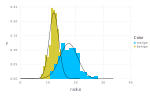

In [175]:
plots[1]

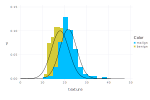

In [176]:
plots[2]

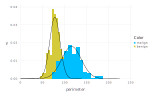

In [177]:
plots[3]

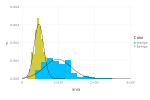

In [178]:
plots[4]

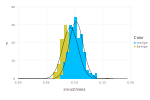

In [179]:
plots[5]

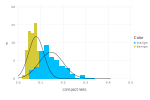

In [180]:
plots[6]

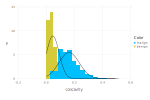

In [181]:
plots[7]

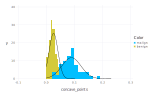

In [182]:
plots[8]

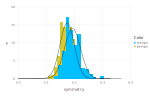

In [183]:
plots[9]

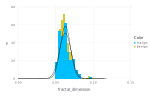

In [184]:
plots[10]

Si l'on utilise uniquement ces lois avec le modèle bayésien naïf (voir section 4), on obtient un score de 89% sur les données d'entrainement, et de 78% sur les données de test. On peux donc faire mieux!

## 3.2 Recherche de nouvelles lois

La loi normale semble convenir pour la plupart des attributs. Néanmoins, pour la compacité et la concavité, il est clair que de meilleures lois peuvent être définies.

Le temps nous étant compté, on utilisera cette fois la fonction *fit* pour approximer la loi a posteriori. Ainsi, au lieu d'utiliser la vraie loi prédicitve, on se servira d'estimateurs. On fera donc la même approximation que dans le devoir 8:

$$f_{(\tilde{X}_1|\tilde{Y}=0)}(\tilde{x}_1) \approx f_{(\tilde{X}_1|\tilde{Y}=0, \hat{\boldsymbol{\theta}}_{01})}(\tilde{x}_1)$$

On commencera avec les lois qui nous semblent les plus probables sur la compacité des tumeurs bénignes.

In [185]:
gamma = fit(Gamma{Float64}, benign[!, :compactness])
beta = fit(Beta{Float64}, benign[!, :compactness])
lognormal = fit(LogNormal{Float64}, benign[!, :compactness])

LogNormal{Float64}(μ=-2.6110368057024393, σ=0.40720069424215255)

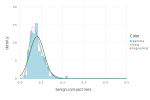

In [186]:
Gadfly.plot(
    layer(x -> pdf(gamma, x), 0, 0.5, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.5, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.5, color=["lognormal"]),
    layer(x -> pdf(preds_0[6], x), 0, 0.5, Theme(default_color=colorant"black")),
    layer(x=benign[!, :compactness], Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.compactness"), Guide.ylabel("density")
)

Ces trois lois semblent mieux décrire la compacité des tumeurs que la loi normale. Pour comparer les différents modèles, nous utiliserons le BIC.

In [187]:
# Tous nos modèles ont deux paramètres
# k=2
df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(preds_0[6], benign[!, :compactness]) - log(n₀)])
push!(df_bic, ["gamma", loglikelihood(gamma, benign[!, :compactness]) - log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, benign[!, :compactness]) - log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, benign[!, :compactness]) - log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 554.637 │
│ 2   │ gamma     │ 585.012 │
│ 3   │ beta      │ 582.395 │
│ 4   │ lognormal │ 588.566 │

Devançant la loi gamma de presque trois points, le modèle le plus probable pour nos données est la lognormale, ce qui semble correspondre à ce qu'on peut voir sur le graphique plus haut. Nous allons maintenant appliquer ces mêmes modèles aux autres attributs. Nous en profiterons aussi pour voir la qualité de la loi prédictive par rapport à la loi normale avec paramètres estimés.

In [188]:
bic_malign = DataFrame(Student = Float64[], Normal=Float64[], Gamma=Float64[], Beta=Float64[], LogNormal=Float64[])
for i=1:10
    tag = tags[i]
    y = malign[:, tag]
    gammaValid = minimum(y) > 0
    betaValid = minimum(y) >= 0 && maximum(y) <=1

    push!(bic_malign, [
        loglikelihood(preds_1[i], y) - log(n₀),
        loglikelihood(fit(Normal, y), y) - log(n₀),
        gammaValid ? loglikelihood(fit(Gamma{Float64}, y), y) - log(n₀) : -Inf,
        betaValid ? loglikelihood(fit(Beta{Float64}, y), y) - log(n₀) : -Inf,
        gammaValid ? loglikelihood(fit(LogNormal{Float64}, y), y) - log(n₀) : -Inf
    ])
end
bic_malign

10×5 DataFrame
│ Row │ Student  │ Normal   │ Gamma    │ Beta    │ LogNormal │
│     │ Float64  │ Float64  │ Float64  │ Float64 │ Float64   │
├─────┼──────────┼──────────┼──────────┼─────────┼───────────┤
│ 1   │ -447.939 │ -447.95  │ -445.529 │ -Inf    │ -445.683  │
│ 2   │ -476.387 │ -476.961 │ -472.313 │ -Inf    │ -472.005  │
│ 3   │ -775.818 │ -775.854 │ -772.596 │ -Inf    │ -772.407  │
│ 4   │ -1256.52 │ -1256.84 │ -1245.02 │ -Inf    │ -1244.61  │
│ 5   │ 502.377  │ 502.358  │ 504.855  │ 504.623 │ 505.507   │
│ 6   │ 253.247  │ 253.091  │ 261.972  │ 261.443 │ 260.628   │
│ 7   │ 202.449  │ 202.287  │ 207.134  │ 208.077 │ 197.659   │
│ 8   │ 332.063  │ 331.968  │ 336.339  │ 336.652 │ 330.856   │
│ 9   │ 362.142  │ 361.858  │ 366.592  │ 365.533 │ 367.963   │
│ 10  │ 583.289  │ 582.984  │ 588.615  │ 588.13  │ 590.802   │

In [189]:
bic_benign = DataFrame(Student = Float64[], Normal=Float64[], Gamma=Float64[], Beta=Float64[], LogNormal=Float64[])
for i=1:10
    tag = tags[i]
    y = benign[:, tag]
    gammaValid = minimum(y) > 0
    betaValid = minimum(y) >= 0 && maximum(y) <=1

    push!(bic_benign, [
        loglikelihood(preds_0[i], y) - log(n₀),
        loglikelihood(fit(Normal, y), y) - log(n₀),
        gammaValid ? loglikelihood(fit(Gamma{Float64}, y), y) - log(n₀) : -Inf,
        betaValid ? loglikelihood(fit(Beta{Float64}, y), y) - log(n₀) : -Inf,
        gammaValid ? loglikelihood(fit(LogNormal{Float64}, y), y) - log(n₀) : -Inf
    ])
end
bic_benign

10×5 DataFrame
│ Row │ Student  │ Normal   │ Gamma    │ Beta    │ LogNormal │
│     │ Float64  │ Float64  │ Float64  │ Float64 │ Float64   │
├─────┼──────────┼──────────┼──────────┼─────────┼───────────┤
│ 1   │ -563.354 │ -563.365 │ -566.61  │ -Inf    │ -569.844  │
│ 2   │ -799.028 │ -799.284 │ -783.953 │ -Inf    │ -779.347  │
│ 3   │ -1103.86 │ -1103.86 │ -1107.36 │ -Inf    │ -1110.84  │
│ 4   │ -1791.13 │ -1791.23 │ -1790.29 │ -Inf    │ -1796.35  │
│ 5   │ 806.006  │ 805.65   │ 813.816  │ 813.002 │ 816.184   │
│ 6   │ 554.637  │ 554.0    │ 585.012  │ 582.395 │ 588.566   │
│ 7   │ 481.238  │ 476.358  │ -Inf     │ -Inf    │ -Inf      │
│ 8   │ 772.072  │ 771.793  │ -Inf     │ -Inf    │ -Inf      │
│ 9   │ 634.021  │ 633.71   │ 640.159  │ 638.974 │ 641.573   │
│ 10  │ 1011.65  │ 1010.64  │ 1023.85  │ 1022.49 │ 1029.42   │

On voit que pour certaines variables, notamment la compacité (index 6), le BIC penche décisivement en faveur des autres modèles (différence supérieure à 2). On remarque au passage que, pour un modèle utilisant la loi normale, le facteur de Bayes entre la loi prédictive et l'estimation par maximum de vraisemblance penche toujours en faveur de la loi prédictive, mais rarement de façon décisive.

Néanmoins, certaines des valeurs de concavité (index 7 et 8) sont en dessous de 0 dans les tumeurs bénignes. C'est plutôt dommage, surtout que visuellement, la loi normale était plutôt mauvaise pour modéliser ces valeurs! De plus, selon le BIC, ces modèles conviennent mieux aux valeurs des tumeurs malignes, comme on peut le voir ci-dessous:

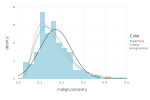

In [190]:
y = malign[:, :concavity]

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

Gadfly.plot(
    layer(x -> pdf(gamma, x), 0, 0.5, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.5, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.5, color=["lognormal"]),
    layer(x -> pdf(preds_1[7], x - 0.01), 0, 0.5, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("malign.concavity"), Guide.ylabel("density")
)

On tentera donc de gérer ces valeurs négatives, pour utiliser les lois proposées sur les données de concavité.

In [191]:
minimum(benign[!, tags[7]])

-0.0007679639517163341

In [192]:
minimum(benign[!, tags[8]])

-0.0004537938092701921

In [193]:
count(val-> val <= 0, benign[:, :concavity])

4

In [194]:
count(val-> val <= 0, benign[:, :concave_points])

3

Très peu de valeurs sont inférieures ou égales à 0, et celles qui le sont sont très proches de 0. On peut donc se permettre de les ramener à une valeur juste au-dessus de 0.

Il faudra toutefois se rappeler d'effectuer la même transformation aux données de test!

On commencera avec la concavité.

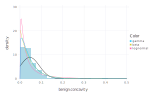

In [195]:
y = benign[:, :concavity]
y = map(val -> val <= 0 ? 0.0001 : val, y)

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

Gadfly.plot(
    layer(x -> pdf(gamma, x), 0, 0.5, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.5, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.5, color=["lognormal"]),
    layer(x -> pdf(preds_0[7], x), 0, 0.5, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.concavity"), Guide.ylabel("density")
)

In [196]:
# Tous nos modèles ont deux paramètres
# k=2
df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(preds_0[7], y) - log(n₀)])
push!(df_bic, ["gamma", loglikelihood(gamma, y) - log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, y) - log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, y) - log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 481.308 │
│ 2   │ gamma     │ 585.652 │
│ 3   │ beta      │ 583.001 │
│ 4   │ lognormal │ 525.976 │

Tous ces modèles sont nettements suprérieures à la loi normale. On remarque toutefois sur le graphique qu'ils ne semblent pas très bien suivre les données. On tentera donc un autre technique pour inclure les valeurs négative : décaler les données.

Le décalage de 0.01 a été choisi visuellement comme celui qui permet aux lois de mieux suivre les données. On pourrait faire un travail pour maximiser la vraisemblance de ce paramètre, mais pour l'instant, comme nous voulons vraiment juste améliorer nos prédictions par rapport à la loi normale, nous nous sommes contentés de cette approximation.

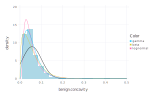

In [197]:
decalage = 0.01
y = benign[:, :concavity] .+ decalage

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

Gadfly.plot(
    layer(x -> pdf(gamma, x), 0, 0.5, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.5, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.5, color=["lognormal"]),
    layer(x -> pdf(preds_0[7], x - decalage), 0, 0.5, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.concavity"), Guide.ylabel("density")
)

In [198]:
decalage = 0.01
y = benign[:, :concavity] .+ decalage
# Pour calculer le BIC avec ces nouvelles données, on devra adapter la loi prédictive
pred = loi_predictive(y)

df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(pred, y) - log(n₀)])
# Le rajout du paramètre de décalage rajoute un paramètre à notre modèle!
# Cela n'affecte pas la loi normale, puisque ce paramètre correspond à la moyenne.
# k=3
push!(df_bic, ["gamma", loglikelihood(gamma, y) - 3/2 * log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, y) - 3/2 * log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, y) - 3/2 * log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 481.238 │
│ 2   │ gamma     │ 574.071 │
│ 3   │ beta      │ 556.268 │
│ 4   │ lognormal │ 582.719 │

La gamma de la première mise à niveau a à peu près le même BIC que la lognormae de la seconde. On peut donc choisir l'un ou l'autre de ces modèles.

On poursuit avec les points concaves. On appliquera la même démarche que pour la concavité.

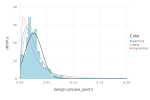

In [199]:
y = benign[:, :concave_points]
y = map(val -> val <= 0 ? 0.0001 : val, y)

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

Gadfly.plot(
    layer(x -> pdf(gamma, x), 0, 0.2, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.2, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.2, color=["lognormal"]),
    layer(x -> pdf(preds_0[8], x), 0, 0.2, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.concave_points"), Guide.ylabel("density")
)

In [200]:
# Tous nos modèles ont deux paramètres
# k=2
df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(preds_0[8], y) - log(n₀)])
push!(df_bic, ["gamma", loglikelihood(gamma, y) - log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, y) - log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, y) - log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 772.215 │
│ 2   │ gamma     │ 778.337 │
│ 3   │ beta      │ 768.9   │
│ 4   │ lognormal │ 709.116 │

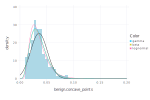

In [201]:
y = benign[:, :concave_points]
y = y .+ 0.01

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

Gadfly.plot(
    layer(x -> pdf(gamma, x), 0, 0.2, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.2, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.2, color=["lognormal"]),
    layer(x -> pdf(preds_0[8], x-0.01), 0, 0.2, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.concave_points"), Guide.ylabel("density")
)

In [202]:
df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(loi_predictive(y), y) - log(n₀)])
push!(df_bic, ["gamma", loglikelihood(gamma, y) - 3/2 * log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, y) - 3/2 * log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, y) - 3/2 * log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 772.072 │
│ 2   │ gamma     │ 791.125 │
│ 3   │ beta      │ 790.873 │
│ 4   │ lognormal │ 787.946 │

## 3.3 Choix du modèle

Donnant suite à notre analyse exploratoire, nous avons choisi les modèles que seront utlisés pour le bayésien naïf. Nous en avons aussi profité pour sélectionner les variables, en fonction de leur pertinence et de la colinéarité.

Les variables perimeter, area et concave_points seront retirées ainf de diminuer la multicolinéarité. On enlève aussi fractal_dimensions, qui n'est visuellement pas pertinente.

Cela nous laisse avec les variables suivantes, que nous modéliserons avec le modèle qui présente de le meilleur BIC. En cas de doute ($\Delta$BIC < 2), on choisit un modèle qui convient aux deux ensembles de données, par souci de cohérence.
- radius : Normale
- texture : LogNormale
- smoothness : LogNormale
- compactness : LogNormale
- concavity : Gamma (avec modification des valeurs négatives)
- symmetry : LogNormale

In [203]:
variables = [1, 2, 5, 6, 7, 9]

for i=[2, 5, 6, 9]
    preds_0[i] = fit(LogNormal, benign[:, tags[i]])
    preds_1[i] = fit(LogNormal, malign[:, tags[i]])
end

preds_0[7] = fit(Gamma, map(val-> val <= 0 ? 0.0001 : val, benign[:, :concavity]))
preds_1[7] = fit(Gamma, malign[:, :concavity])

Gamma{Float64}(α=4.617073814995688, θ=0.03501547207251189)

In [204]:
for i=variables
    y₁ = malign[:, tags[i]]
    y₀ = benign[:, tags[i]]
    plots[i] = Gadfly.plot(
        layer(x->pdf(preds_0[i], x), 0, 1.2 * maximum(y₀), Theme(default_color=colorant"black")),
        layer(x->pdf(preds_1[i], x), 0, 1.2 * maximum(y₁), Theme(default_color=colorant"black")),
        layer(x=y₁, Geom.histogram(bincount=floor(sqrt(n₁)), density=true), color = ["malign"]),
        layer(x=y₀, Geom.histogram(bincount=floor(sqrt(n₀)), density=true), color = ["benign"])
    )
end

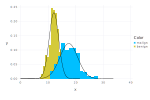

In [205]:
plots[1]

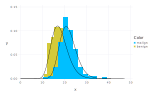

In [206]:
plots[2]

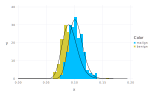

In [207]:
plots[5]

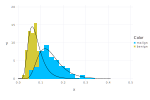

In [208]:
plots[6]

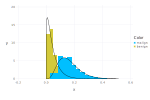

In [209]:
plots[7]

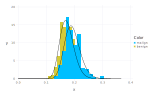

In [210]:
plots[9]

## 4. Probabilité d'une tumeur maligne

On utilisera un modèle bayésien naïf à plusieurs variables pour déterminer si une tumeur est maligne ou bénigne

In [211]:
α = 1
β = 1
n₀ = size(benign, 1)
n₁ = size(malign, 1)
n = n₀ + n₁
p₀ = (β + n₀)/(α + β + n)
p₁ = (α + n₁)/(α + β + n)

0.37636761487964987

In [212]:
function vraisemblance_maligne(row::DataFrameRow, selected_variables)
    q₀ = log(p₀)
    q₁ = log(p₁)
    
    for i=selected_variables
        q₀ += log(pdf(preds_0[i], row[tags[i]]))
        
        q₁ += log(pdf(preds_1[i], row[tags[i]]))
    end

    return q₁ - q₀
end

vraisemblance_maligne (generic function with 1 method)

In [213]:
results = map(row -> vraisemblance_maligne(row, variables), eachrow(data))

455-element Array{Float64,1}:
   7.677242501103633
  -4.041046451650609
  -2.3599692634155307
  -3.772994046957568
  10.864486813432784
   1.57000427199612
  27.056348836140415
   4.045170695603826
   4.141190805117005
 -18.553807545206887
 -21.791476919686524
  10.449526337857405
  -7.5099630247763685
   ⋮
  -2.2130731127255165
  -5.856395046311958
  -7.413771235130006
  17.908851068104266
  -4.6058580700486145
  -4.006856423117462
  -3.0936253174729083
  -9.21365100329951
  -5.6450520459289795
  -2.4139923632527336
  -1.3252381045859818
  12.433625513639338

In [214]:
predictions = results .> 0

455-element BitArray{1}:
 1
 0
 0
 0
 1
 1
 1
 1
 1
 0
 0
 1
 0
 ⋮
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 1

In [215]:
mean(predictions)

0.3868131868131868

In [216]:
correctrate(data[!, :diagnosis], predictions)

0.9274725274725275

### 4.1 Cross validation

Nous nous sommes demandés si enlever des variables colinéaires améliorait effectivement les prédictions. Pour cela, il faut séprarer notre ensemble de données entre entrainement et validation, puisque si l'utilisation de toutes les variables va toujours améliorer notre précision sur l'ensemble d'entrainement, elle peut la réduire sur une ensemble de test.

Il faut aussi choisir des lois pour les autres variables que nous avions rejetées.

- perimeter : Normale
- area : Normale
- concave_points : Gamma avec recentrage des données
- fractal_dimension : LogNormale

In [217]:
function bayesian_predict(m_train, b_train, valid, variables)
    # Lois normales
    for attr=[1, 3, 4]
        preds_0[attr] = loi_predictive(b_train[:, tags[attr]])
        preds_1[attr] = loi_predictive(m_train[:, tags[attr]])
    end

    # Lois lognormales
    for attr=[2, 5, 6, 9, 10]
        preds_0[attr] = fit(LogNormal, b_train[:, tags[attr]])
        preds_1[attr] = fit(LogNormal, m_train[:, tags[attr]])
    end

    # Lois gamma
    # Pour la concavité des tumeurs bénignes, on modifie les points sous 0
    # On n'applique pas ces modifications aux tumeurs malignes, puisqu'aucune valeur ne se trouve sous 0
    y = map(val -> val <=0 ? 0.00001 : val, b_train[:, :concavity])
    preds_0[7] = fit(Gamma, y)
    preds_1[7] = fit(Gamma, m_train[:, :concavity])
    # Pour les points concaves des tumeurs bénignes, on décale tout de 0.01
    # Ces modifications devront aussi s'appliquer aux tumeurs malignes
    preds_0[8] = fit(Gamma, b_train[:, :concave_points] .+ 0.01)
    preds_1[8] = fit(Gamma, m_train[:, :concave_points] .+ 0.01)

    # Il faut appliquer les mêmes changements à l'ensemble de test
    valid = copy(valid)
    valid[!, :concavity] = map(val -> val <=0 ? 0.00001 : val, valid[:, :concavity])
    valid[!, :concave_points] = valid[:, :concave_points] .+ 0.01

    results = map(row->vraisemblance_maligne(row, variables), eachrow(valid))
    return results
end

bayesian_predict (generic function with 1 method)

On réutilisera la méthode `findAllIndexes` du KNN.

In [218]:
function bayesian_split_data(i::Int64, nb_blocks::Int64)
    malign_indexes = findAllIndexes(n₁, nb_blocks)
    benign_indexes = findAllIndexes(n₀, nb_blocks)
    
    m_range = malign_indexes[i][1]:malign_indexes[i][2]
    malign_valid = malign[m_range, :]
    malign_train = malign[Not(m_range), :]

    b_range = benign_indexes[i][1]: benign_indexes[i][2]
    benign_valid = benign[b_range, :]
    benign_train = benign[Not(b_range), :]
    
    valid = append!(malign_valid, benign_valid)
    
    return malign_train, benign_train, valid
end

bayesian_split_data (generic function with 1 method)

On peut maintenant appliquer nos modèles à chaque bloc

In [219]:
rates_all = []
rates_selected = []
selected_variables = [1, 2, 5, 6, 7, 9]
nb_blocks = 5
for i=1:nb_blocks
    m_train, b_train, valid = bayesian_split_data(i, nb_blocks)
    
    # Prédictions avec variables sélectionnées
    results = bayesian_predict(m_train, b_train, valid, selected_variables)
    predictions = results .> 0
    push!(rates_selected, correctrate(predictions, valid.diagnosis))
    
    # Prédictions avec toutes les variables
    results = bayesian_predict(m_train, b_train, valid, 1:10)
    predictions = results .> 0
    push!(rates_all, correctrate(predictions, valid.diagnosis))
end

In [220]:
mean(rates_all)

0.9384100440622181

In [221]:
mean(rates_selected)

0.9273955513085947

Notre modèle ne semble pas être trop sensible à la colinéarité, ou aux variables presque inutiles. On peut donc se peremttre d'utiliser l'ensemble des variables pour le modèle final.

### 4.2 Application du modèle à l'ensemble de test

In [222]:
test = CSV.read("test.csv")
first(test, 5)

5×11 DataFrame. Omitted printing of 5 columns
│ Row │ id    │ radius  │ texture │ perimeter │ area    │ smoothness │
│     │ Int64 │ Float64 │ Float64 │ Float64   │ Float64 │ Float64    │
├─────┼───────┼─────────┼─────────┼───────────┼─────────┼────────────┤
│ 1   │ 456   │ 12.981  │ 19.2604 │ 84.5712   │ 504.918 │ 0.096902   │
│ 2   │ 457   │ 13.0232 │ 16.2885 │ 82.2969   │ 516.305 │ 0.0947715  │
│ 3   │ 458   │ 14.9065 │ 16.7207 │ 97.7443   │ 676.309 │ 0.116636   │
│ 4   │ 459   │ 21.2952 │ 15.2586 │ 140.335   │ 1385.54 │ 0.0987041  │
│ 5   │ 460   │ 14.3035 │ 21.6312 │ 92.4501   │ 639.77  │ 0.0993152  │

In [223]:
# Cette fois-ci, l'ensemble d'entrainement repose sur toutes les données disponibles
results = bayesian_predict(malign, benign, test)

predictions = results .> 0
mean(predictions)

LoadError: MethodError: no method matching bayesian_predict(::DataFrame, ::DataFrame, ::DataFrame)
Closest candidates are:
  bayesian_predict(::Any, ::Any, ::Any, !Matched::Any) at In[217]:1

In [224]:
final = DataFrame(id = test[!,:id], diagnosis = predictions)
CSV.write("bayes_naif.csv",final)

LoadError: DimensionMismatch("column :id has length 114 and column :diagnosis has length 92")

Ce modèle a obtenu une précision de 80% sur l'ensemble de test ¯\\\_(ツ)_/¯

## 5. Analyse critique

- Le travail sur la loi prédictive n'était pas vraiment nécessaire finalement, puisque d'autres modèles que la loi normale se sont assez souvent révélés de meilleure qualité, et même quand la loi normale est le meilleure modèle, la loi prédictive n'est pas significativement meilleure que l'estimation des paramètres d'après le BIC.

# Comparaison de modèles

Dans cette partie, nous nous sommes demandé si l'on pouvait utiliser plusieurs modèles pour améliorer nos prédictions, en comparant les résultats qui diffèrent entre eux.

En comparant deux modèles, il y a 3 cas de figure :
- Les modèles ont tous les deux raison
- Les modèles ont tous les deux tort
- Les modèles se contredisent

En analysant les données corresondant à chacun de ces cas, on pourrait savoir quand prioriser un modèle par rapport à l'autre.

In [225]:
KNN_predictions = []
bayesian_predictions = []

nb_blocks = 15
indexes = findAllIndexes(size(X_test)[1], nb_blocks)


for i=1:nb_blocks
    m_train, b_train, valid = bayesian_split_data(i, nb_blocks)
    
    # Prédictions avec toutes les variables
    results = bayesian_predict(m_train, b_train, valid, 1:10)
    push!(bayesian_predictions, results)
    
    sub_X_train, sub_X_test, sub_y_train, true_y_test = split_train_test(X_train, y_train, indexes[i])
    sub_y_test = knn(5, sub_X_train, sub_y_train, sub_X_test)
    push!(KNN_predictions, sub_y_test)

end